This notebook follows from rotate_no_resize_inference and running the nn-Unet model. It is used to find the Dice and sDice metric results. This script is to calculate the DICE, sDICE, and the Hausdorff distance of two sets of labels. The sets of labels are called (a) original for the manual labels and (b) predicted for the predicted labels
Documentation of metrics can be found here: https://github.com/deepmind/surface-distance


In [1]:
#Necessary imports
import os
import shutil

from ast import Break
import os
import SimpleITK as sitk
import numpy as np

import re

from absl.testing import absltest
from absl.testing import parameterized
import surface_distance
from surface_distance import metrics

import pandas as pd



In [2]:
#Set all paths

nnUnet_res= '/home/chloe/nnUNet_Results/Task603_SettingUp_Res'
predicted_labels = 'results/control_results/control_predictions'
rot_dir = 'results/control_results/control_images'

# Define the path to where you store transformed data and where to store nnUnet data
original_label_dir = 'data/labelsTs'
transformed_labels = 'results/control_results/control_labels'
stored_control_labels = 'results/control_results/stored_control_labels'

Only run two below if needed

Copy the results to the current working directory

In [3]:
#Maybe add to only move image outputs
file_names = os.listdir(nnUnet_res)

#Make list of strings to create directory: original, control_image, load_save
control_names = ['original', 'control', 'load_save']

for file_name in file_names:
    for name in control_names:
        stored_rot_path = os.path.join(predicted_labels,name)
        if not os.path.exists(stored_rot_path):
            os.makedirs(stored_rot_path)
        if name == 'original':
            if file_name.endswith("pre.nii.gz"):
                shutil.copy(os.path.join(nnUnet_res, file_name), stored_rot_path)
        if file_name.endswith(name+"_image_0.0_0.0_0.0.nii.gz"):
            shutil.copy(os.path.join(nnUnet_res, file_name), stored_rot_path)
        


Move transformed manual labels into folder for computing Dice and sDice metrics

In [4]:
#Store original, untransformed labels
original_labels = os.listdir(original_label_dir)
stored_orig_path = os.path.join(stored_control_labels,'original')
if not os.path.exists(stored_orig_path):
            os.makedirs(stored_orig_path)

for label in original_labels:
    shutil.copy(os.path.join(original_label_dir, label), stored_orig_path)

patient_names = os.listdir(transformed_labels)

#Store transformed control labels
for patient in patient_names:
    patient_path = os.path.join(transformed_labels, patient)
    files = os.listdir(patient_path)
    for file_name in files:
        if file_name.endswith("control_label_0.0_0.0_0.0.nii.gz"):
            stored_rot_path = os.path.join(stored_control_labels,'control')
            if not os.path.exists(stored_rot_path):
                os.makedirs(stored_rot_path)
            shutil.copy(os.path.join(patient_path, file_name), stored_rot_path)
        if file_name.endswith("load_save_label_0.0_0.0_0.0.nii.gz"):
            stored_rot_path = os.path.join(stored_control_labels,'load_save')
            if not os.path.exists(stored_rot_path):
                os.makedirs(stored_rot_path)
            shutil.copy(os.path.join(patient_path, file_name), stored_rot_path)

print("Files copied")

Files copied


Give names for predicted labels and rotated manual labels

In [5]:
#Loop over all the rotations

transform_label_dir = transformed_labels
stored_label_folder = stored_control_labels

original_label_path = stored_label_folder 
predicted_label_path = predicted_labels

Set initial values and functions

In [6]:
def generate_np_array_of_single_structure(np_matrix, number):
    single_struct_array = np.where(np_matrix != number, 0, np_matrix)
    return single_struct_array.astype('bool')    # sets all 0-entries to False, and all others to True

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

num_structures = 1 + 1
s_dice_tolerance = 2 #mm

Iterate over file paths to obtain the metric

In [7]:
dice_matrix = np.zeros(num_structures)
hd_matrix = np.zeros(num_structures)
avg_surface_d_matrix = np.zeros(num_structures)
surf_dice_matrix = np.zeros(num_structures)

num_patients = 0
all_numbers = []
for i in range(num_structures):
    all_numbers.append(i)
print("all_numbers: ", all_numbers)

rot_list =  sorted_alphanumeric(os.listdir(predicted_label_path))
first_file_list = sorted_alphanumeric(os.listdir(os.path.join(original_label_path, rot_list[0])))

dice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)
sdice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)

rot_count = -1
for rot in rot_list:
    rot_count = rot_count + 1
    rot_pred_path = os.path.join(predicted_label_path, rot)
    rot_orig_path = os.path.join(original_label_path, rot)
    file_count = -1
    for filename in sorted_alphanumeric(os.listdir(rot_pred_path)):
        print("Predicting", filename)
        file_count = file_count + 1
        num_patients += 1
        dice_arr = np.zeros(num_structures)
        hd_arr = np.zeros(num_structures)
        avg_surface_d_arr = np.zeros(num_structures)
        surf_dice_arr = np.zeros(num_structures)

        # extract the example name
        # first split the path by '/' and take the last result to get the file name
        # then exclude the last 7 characters to exclude the '.nii.gz'
        name = filename.split('/')[-1][:-7]


        ############ ORIGINAL ############

        # read the label file and save it as nifti with correct naming
        orig_name = name.replace("0000_","")
        orig_name = orig_name.replace("image","label")
        original_data_path = rot_orig_path + "/" +  orig_name + ".nii.gz"
        original_img = sitk.ReadImage(original_data_path)  # read the file (file is the path to the label file)
        original_arr = sitk.GetArrayFromImage(original_img)

        # count amount of pixels with different labels
        unique, counts = np.unique(original_arr, return_counts=True)

        ############ PREDICTIONS ############

        # do the same for the corresponding image file
        pred_data_path = rot_pred_path + "/" +  name + ".nii.gz"
        pred_img = sitk.ReadImage(pred_data_path)  # exchange the _labels with _predictions in the file name to get the path to the predictions and reads the predictions
        pred_arr = sitk.GetArrayFromImage(pred_img)                 

        # count amount of pixels with different labels
        unique2, counts2 = np.unique(pred_arr, return_counts=True)

    #for each structure
        for number in range(num_structures):

            # no evalutation for background
            if(number == 0): continue

            if(number in unique2):
                #print("Analyzing structure: ", number)
                original_structure = generate_np_array_of_single_structure(original_arr, number)
                predicted_structure = generate_np_array_of_single_structure(pred_arr, number)

                # 3rd agument spacing_mm: resp. 3-element list-like structure. Voxel spacing in x0, x1 and x2 directions.
                surf_dist = metrics.compute_surface_distances(original_structure, predicted_structure, [3, 1, 1])
                dice = metrics.compute_dice_coefficient(original_structure, predicted_structure)

                # 2nd argument: percent: a float value between 0 and 100
                hd = metrics.compute_robust_hausdorff(surf_dist, 99)
                avg_sd = metrics.compute_average_surface_distance(surf_dist)
                s_dice = metrics.compute_surface_dice_at_tolerance(surf_dist, s_dice_tolerance)

                dice_arr[number] = dice
                hd_arr[number] = hd
                surf_dice_arr[number] = s_dice

            else: 
                # check if a predicted structure is missing
                print("missing structure in prediction: ", number)


            #Fill in array for each file (each row = rotation, each column = patient )
            dice_array[rot_count,file_count] = dice_arr[1]
            sdice_array[rot_count,file_count] = surf_dice_arr[1]

            dice_matrix = np.vstack((dice_matrix, dice_arr))
            hd_matrix = np.vstack((hd_matrix, hd_arr))
            #avg_surface_d_matrix = np.vstack(avg_surface_d_matrix, avg_surface_d_arr)
            surf_dice_matrix = np.vstack((surf_dice_matrix, surf_dice_arr))  

all_numbers:  [0, 1]
Predicting HN_P002_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P003_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P005_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P007_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P008_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P009_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P010_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P011_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P014_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P016_pre_0000_control_image_0.0_0.0_0.0.nii.gz
Predicting HN_P002_pre_0000_load_save_image_0.0_0.0_0.0.nii.gz
Predicting HN_P003_pre_0000_load_save_image_0.0_0.0_0.0.nii.gz
Predicting HN_P005_pre_0000_load_save_image_0.0_0.0_0.0.nii.gz
Predicting HN_P007_pre_0000_load_save_image_0.0_0.0_0.0.nii.gz
Predicting HN_P008_pre_0000_load_save_image_0.0_0.0_0.0.nii.gz
Predicting HN_P009_pre_0000_load_save_image_0.0_0.0_0.

In [8]:

short_rot_list = rot_list
print(short_rot_list)

short_file_list = [s.replace('_pre_control_label_0.0_0.0_0.0.nii.gz','') for s in first_file_list]
print(short_file_list)

['control', 'load_save', 'original']
['HN_P002', 'HN_P003', 'HN_P005', 'HN_P007', 'HN_P008', 'HN_P009', 'HN_P010', 'HN_P011', 'HN_P014', 'HN_P016']


Visualize Dice and sDice arrays

In [9]:
print("Dice:")
dice_table = pd.DataFrame(dice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(dice_table)

print("sDice:")
sdice_table = pd.DataFrame(sdice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(sdice_table)

Dice:
            HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009  \
control    0.625806  0.599211  0.596890  0.605645  0.627882  0.541732   
load_save  0.629937  0.623756  0.605346  0.637399  0.634477  0.557636   
original   0.629937  0.623756  0.605346  0.637399  0.634477  0.557636   

            HN_P010   HN_P011   HN_P014   HN_P016  
control    0.518648  0.502035  0.485366  0.618863  
load_save  0.510480  0.485920  0.484451  0.642874  
original   0.510480  0.485920  0.484451  0.642874  
sDice:
            HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009  \
control    0.370973  0.407131  0.461783  0.495973  0.493964  0.325367   
load_save  0.371996  0.438967  0.487386  0.535320  0.506253  0.333944   
original   0.371996  0.438967  0.487386  0.535320  0.506253  0.333944   

            HN_P010   HN_P011   HN_P014   HN_P016  
control    0.424165  0.358123  0.457956  0.257697  
load_save  0.417245  0.315311  0.444309  0.286198  
original   0.417245  0.315311  0.4443

In [10]:
#Get errors in the table
err_dice_array = dice_array - dice_array[0,:]

err_sdice_array = sdice_array - sdice_array[0,:]

print("Dice Absolute Error:")
abs_err_dice_table = pd.DataFrame(err_dice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_dice_table)

print("sDice Absolute Error:")
abs_err_sdice_table = pd.DataFrame(err_sdice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_sdice_table)

Dice Absolute Error:
            HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009  \
control    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
load_save  0.004131  0.024545  0.008457  0.031754  0.006595  0.015905   
original   0.004131  0.024545  0.008457  0.031754  0.006595  0.015905   

            HN_P010   HN_P011   HN_P014   HN_P016  
control    0.000000  0.000000  0.000000  0.000000  
load_save  0.008169  0.016115  0.000915  0.024011  
original   0.008169  0.016115  0.000915  0.024011  
sDice Absolute Error:
            HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009  \
control    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
load_save  0.001024  0.031836  0.025603  0.039347  0.012288  0.008577   
original   0.001024  0.031836  0.025603  0.039347  0.012288  0.008577   

            HN_P010   HN_P011   HN_P014   HN_P016  
control    0.000000  0.000000  0.000000  0.000000  
load_save  0.006921  0.042813  0.013647  0.028501  
origina

In [11]:
#Get mean absolute value table
print("Mean Absolute Dice Error:")
MAE_dice_table = abs_err_dice_table.mean(axis = 1)
print(MAE_dice_table)

print("Mean Absolute sDice Error:")
MAE_sdice_table = abs_err_sdice_table.mean(axis = 1)
print(MAE_sdice_table)


Mean Absolute Dice Error:
control      0.00000
load_save    0.01406
original     0.01406
dtype: float64
Mean Absolute sDice Error:
control      0.000000
load_save    0.021056
original     0.021056
dtype: float64


<Axes: >

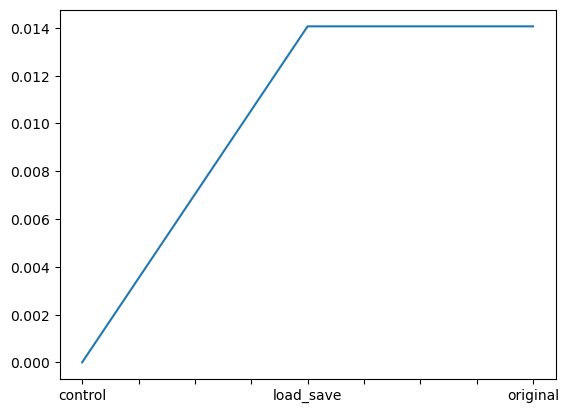

In [12]:
MAE_dice_table.plot()

<Axes: >

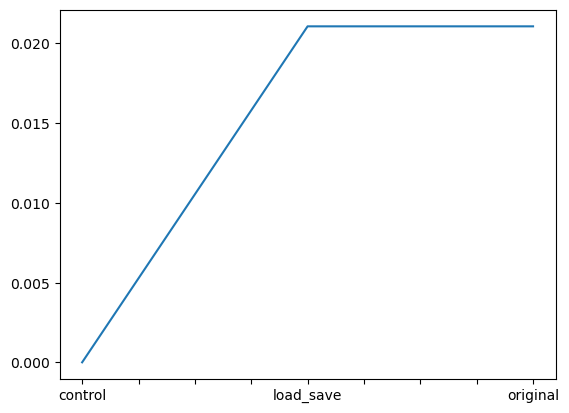

In [13]:
MAE_sdice_table.plot()

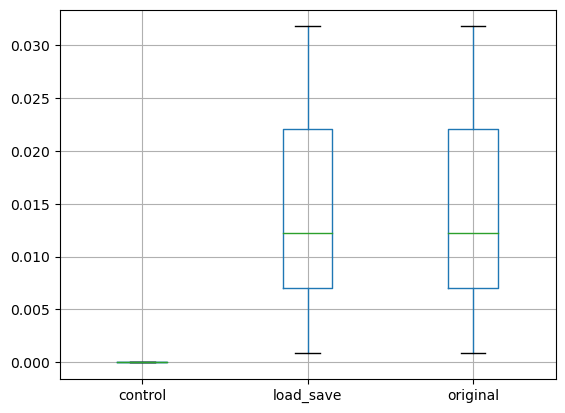

In [14]:
boxplot = abs_err_dice_table.T.boxplot()  

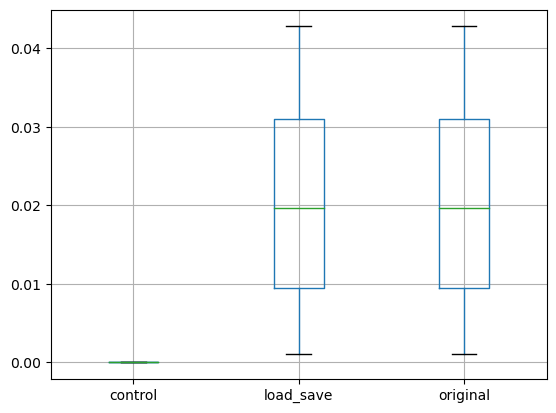

In [15]:
boxplot = abs_err_sdice_table.T.boxplot()  